In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


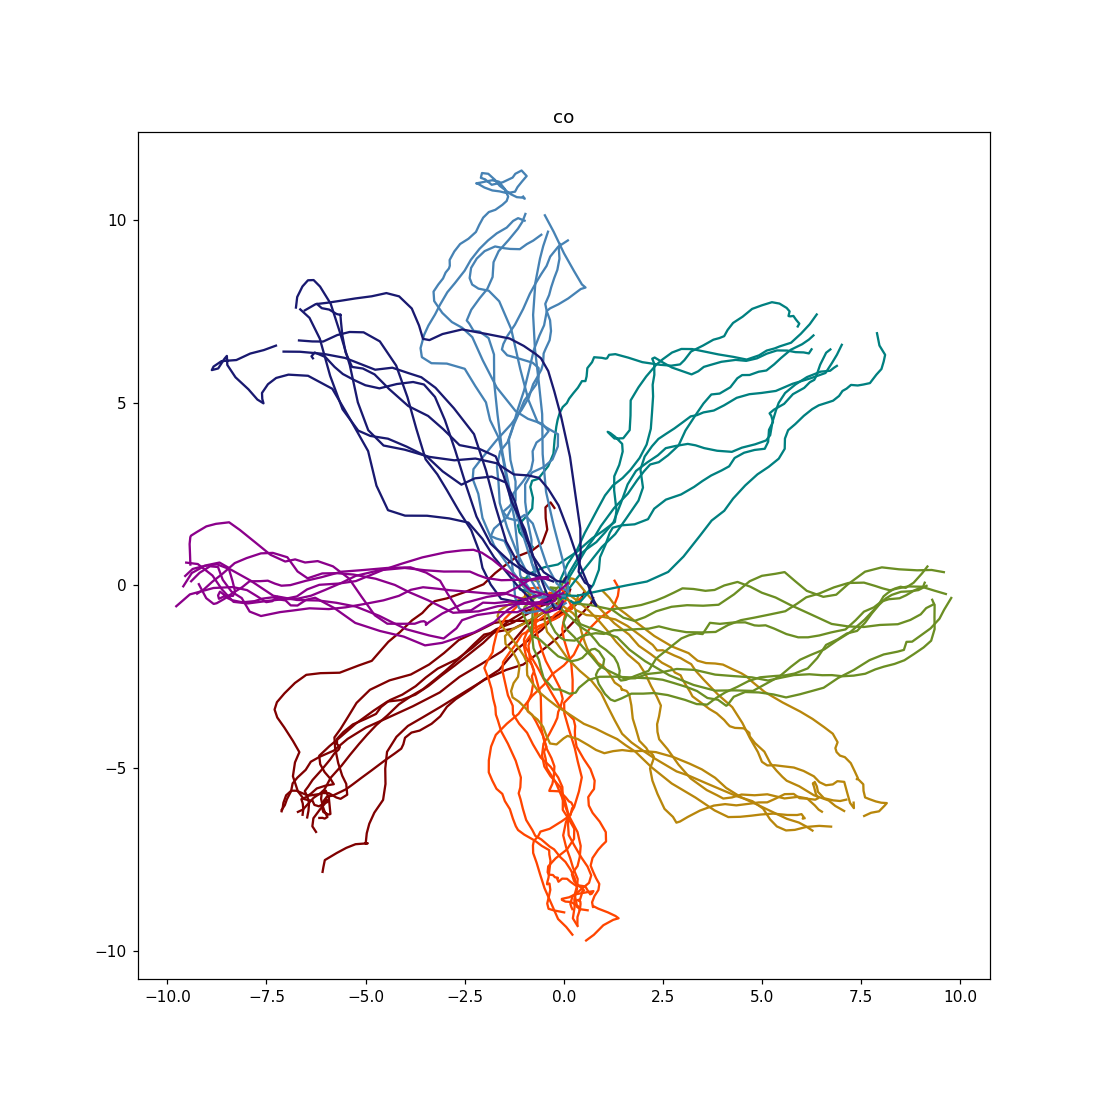

<IPython.core.display.Javascript object>


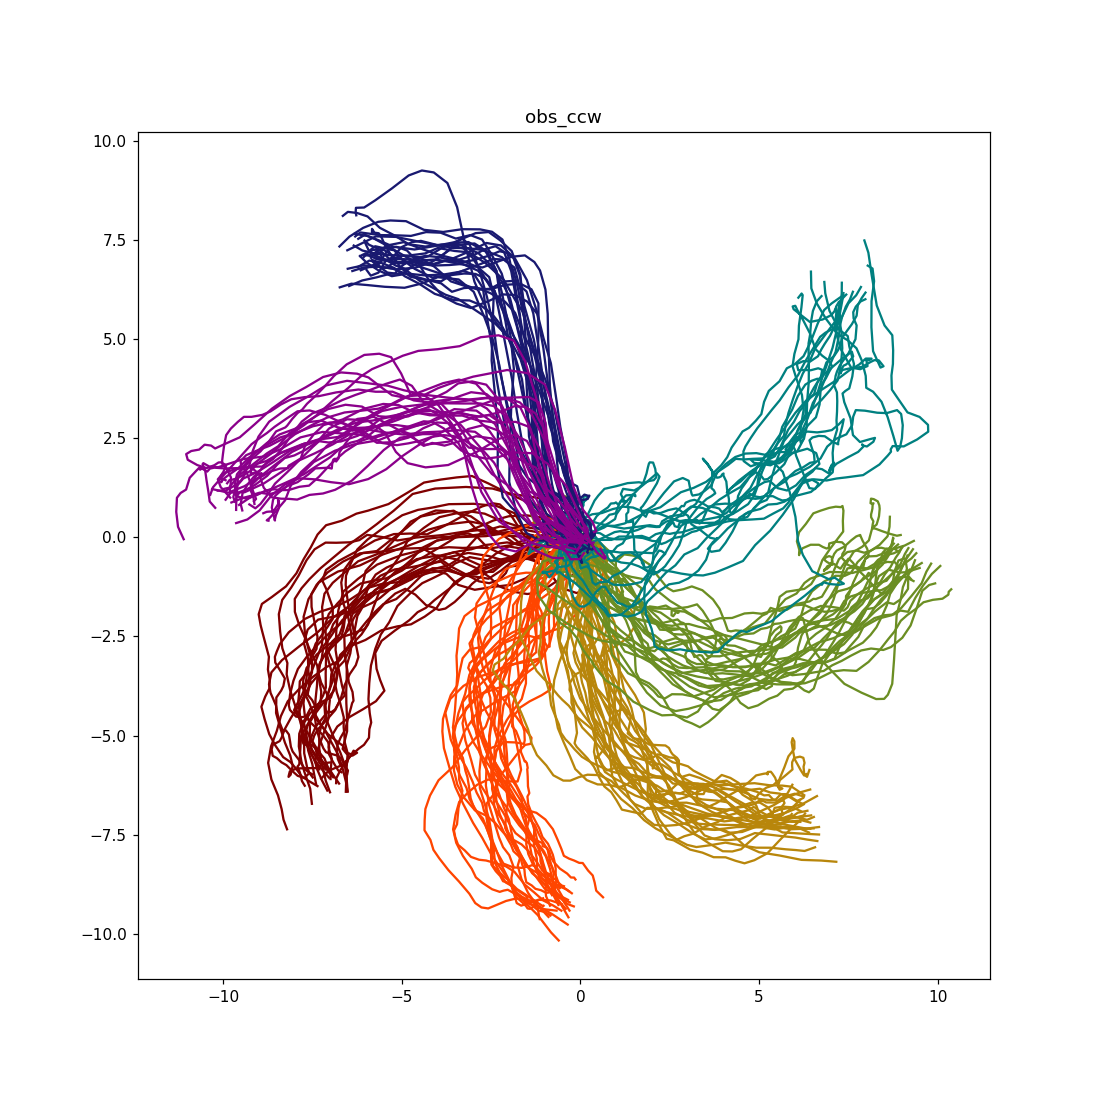

<IPython.core.display.Javascript object>


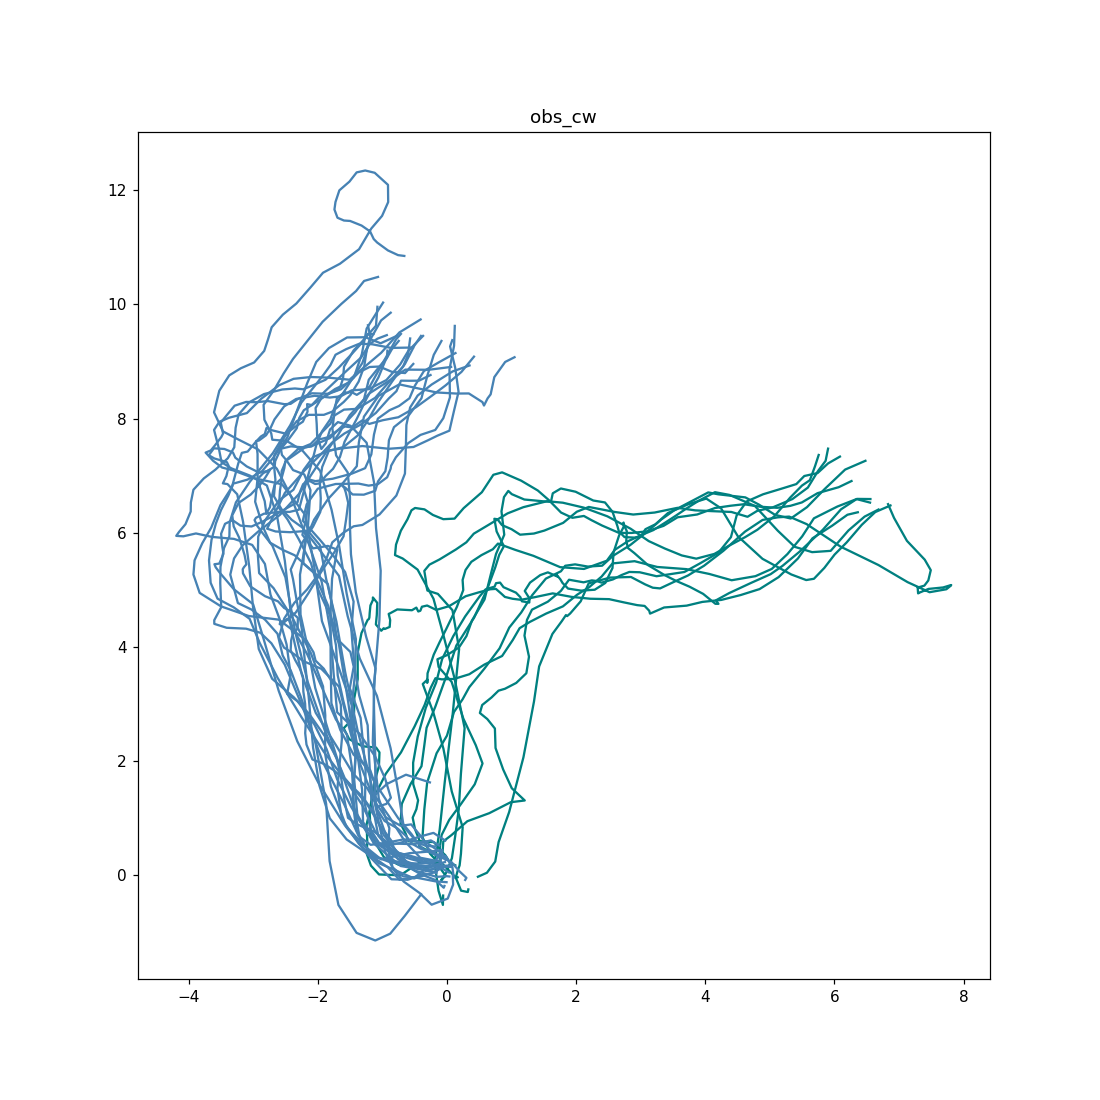

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [6]:
# save_path = os.path.join(save_dir, 'lqr_noise_1000trials.pkl')
save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'lqr_noise_1000trials_expt_noise_diag.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')

<IPython.core.display.Javascript object>


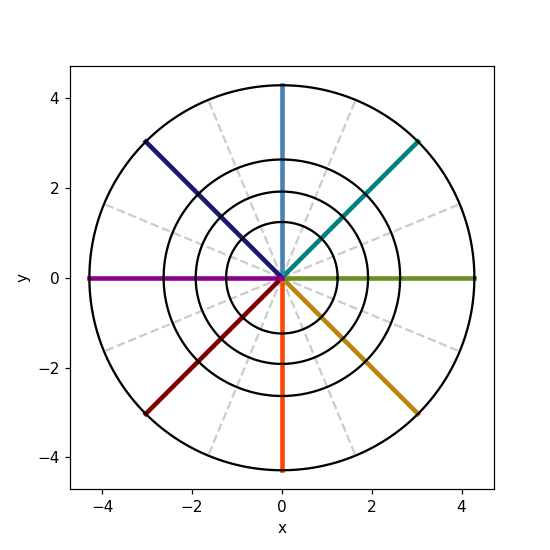

In [7]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

<IPython.core.display.Javascript object>


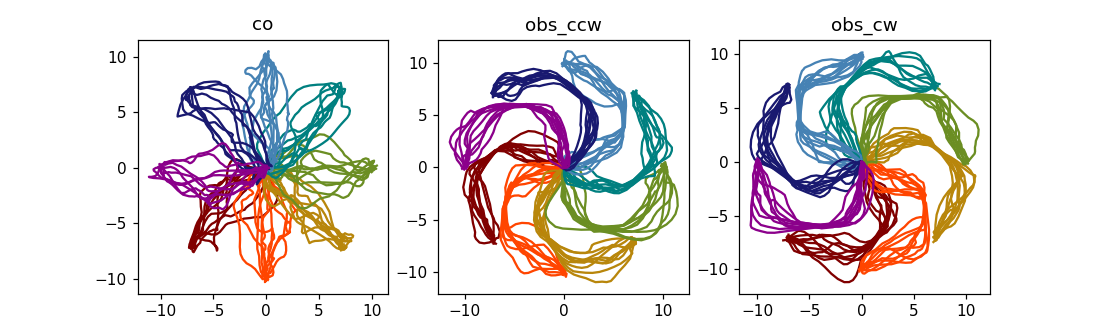

In [8]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_do'
plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']


num_trials_plot = 10
plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

### Decoder

In [36]:
Kn2v = Kn[2:4,:]
Kn2v.shape

(2L, 44L)

<IPython.core.display.Javascript object>


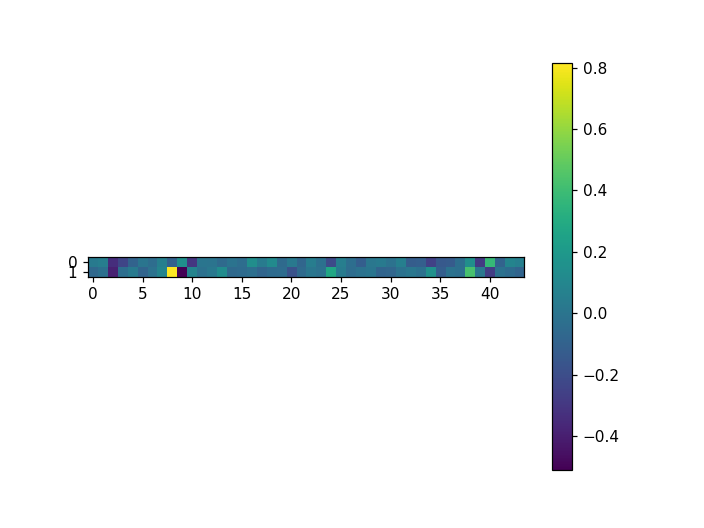

In [37]:
plt.figure()
plt.imshow(Kn2v)
plt.colorbar()

### Check feedback matrices alignment to Kn

In [ ]:
# # TEST SVD of K:
# u,s,vh = np.linalg.svd(K, full_matrices=True)
# smat = np.hstack((np.diag(s), np.zeros((44,5))))
# recon = u*smat*vh
# diff = K-recon
# diff.max()

<IPython.core.display.Javascript object>


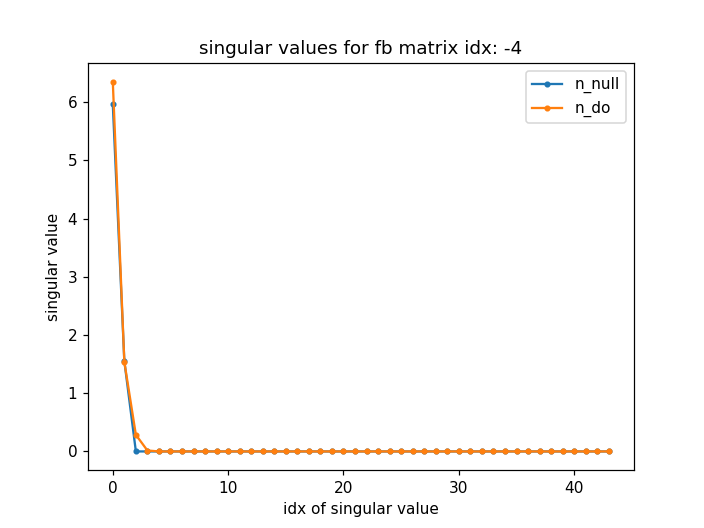

In [53]:
sel_seg = 0
sel_move = (0,1.1)
i=-4#-6

plt.figure()
for m in ['n_null', 'n_do']:
    K = r['move_lqr'][(sel_move[0], sel_move[1], m)]['K_list'][sel_seg][0,i_plt][:,:]
#     for i in range(K_list.shape[1]-2):
    u,s,vh = np.linalg.svd(K, full_matrices=True)
    
    plt.plot(s, '.-', label=m)
plt.title('singular values for fb matrix idx: ' + str(i))
plt.xlabel('idx of singular value')
plt.ylabel('singular value')
plt.legend()
# sel_m = (0,1.1,'n_do')
# i_plt = -6#-219 #-4
# K = r['move_lqr'][sel_m]['K_list'][sel_seg][0,i_plt][:,:]
# # n_do = r['move_lqr'][0,1.1,'n_do']['K_list'][0][0,i_plt][:,:]
# # n_null = r['move_lqr'][0,1.1,'n_null']['K_list'][0][0,i_plt][:,:]

# u,s,vh = np.linalg.svd(K, full_matrices=True)

# plt.figure()
# plt.plot(s, '.-')

In [49]:
#Calculate the angle between the two 
sel_seg = 0
sel_move = (0,1.1)
i=-10#-6
print('angles between decoder and each left singular vector of a feedback matrix')
for m in ['n_null', 'n_do']:
    K = r['move_lqr'][(sel_move[0], sel_move[1], m)]['K_list'][sel_seg][0,i_plt][:,:]
    u,s,vh = np.linalg.svd(K, full_matrices=True)
    
    angle_list = []
    for i in range(3):
        angle_list.append(float(np.rad2deg(scipy.linalg.subspace_angles(Kn2v.T, u[:,i]))))
    
    print(m, angle_list)


angles between decoder and each left singular vector of a feedback matrix
('n_null', [4.753515648096047e-14, 6.27595348906675e-14, 89.99999999999996])
('n_do', [5.7297762244436425, 14.43748723933101, 82.62398265447843])


### Check decoder alignment to neural dynamics A

<IPython.core.display.Javascript object>


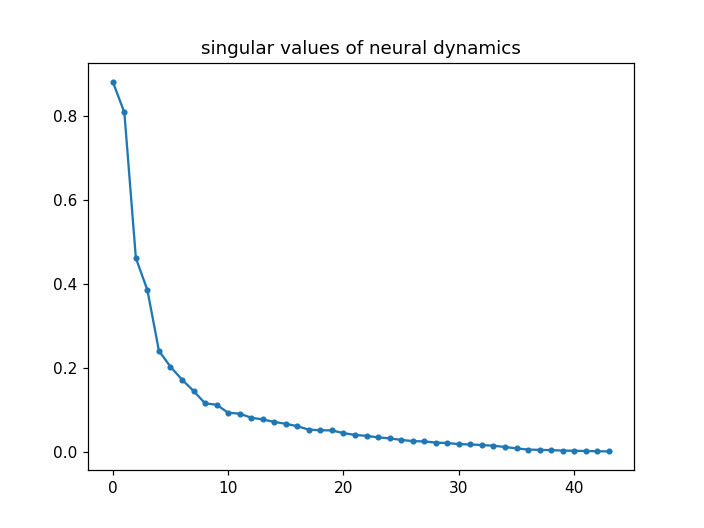

<IPython.core.display.Javascript object>


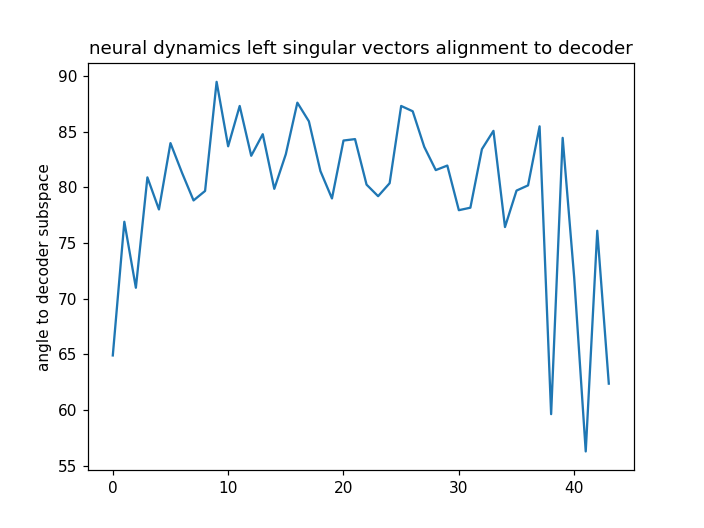

Text(0.5,1,'neural dynamics left singular vectors alignment to decoder')

In [65]:
A = r['A_dic']['n_do'][0:num_neurons, 0:num_neurons]
u,s,vh = np.linalg.svd(A, full_matrices=True)
plt.figure()
plt.plot(s, '.-')
plt.title('singular values of neural dynamics')

angle_list = []
for i in range(u.shape[1]):
    angle_list.append(float(np.rad2deg(scipy.linalg.subspace_angles(Kn2v.T, u[:,i]))))
    
plt.figure()
plt.plot(angle_list)
plt.ylabel('angle to decoder subspace')
plt.title('neural dynamics left singular vectors alignment to decoder')

### Check feedback matrices alignment to neural dynamics A

In [66]:
A = r['A_dic']['n_do'][0:num_neurons, 0:num_neurons]
u_A,s_A,vh_A = np.linalg.svd(A, full_matrices=True)

for m in ['n_null', 'n_do']:
    K = r['move_lqr'][(sel_move[0], sel_move[1], m)]['K_list'][sel_seg][0,i_plt][:,:]
#     for i in range(K_list.shape[1]-2):
    u,s,vh = np.linalg.svd(K, full_matrices=True)

    
    angle_list = []
    for i in range(3):
        angle_list.append([])
        for j in range(u_A.shape[1]):
            a = float(np.rad2deg(scipy.linalg.subspace_angles(u[:,i], u_A[:,j])))
            angle_list[i].append(a)
            


<IPython.core.display.Javascript object>


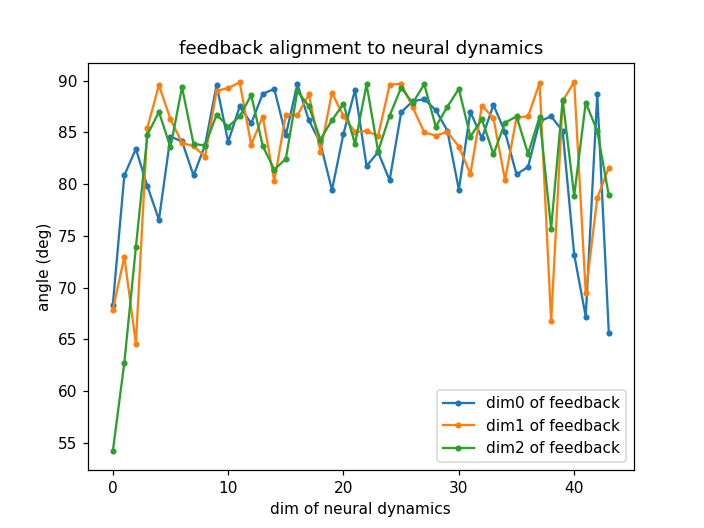

In [71]:
plt.figure()
for i in range(3):
    plt.plot(angle_list[i], '.-', label='dim'+str(i) + ' of feedback')
plt.xlabel('dim of neural dynamics')    
plt.ylabel('angle (deg)')    
plt.title('feedback alignment to neural dynamics')
plt.legend()

<IPython.core.display.Javascript object>


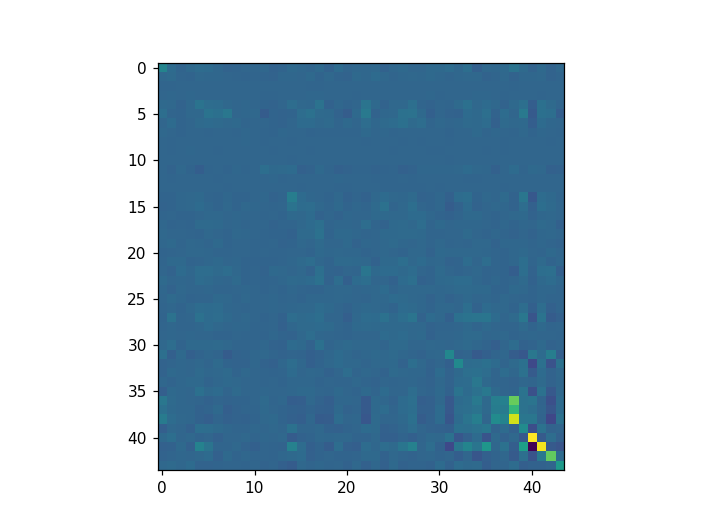

In [60]:
A = r['A_dic']['n_do'][0:num_neurons, 0:num_neurons]
# plt.figure()
# plt.imshow(A)



In [57]:
r['A_dic']['n_do'].shape

(49L, 49L)

In [55]:
r['A_dic'].keys()

['n_null', 'n_do', 'n_o']

In [54]:
r.keys()

['state_dim',
 'Qv_s',
 'num_targets',
 'num_mag_bins_analyze',
 'A_dic',
 'angle_bin_edges',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'mag_bin',
 'angle_bin',
 'state_label',
 'df_mean',
 'mag_bin_c',
 'kin_var',
 'df_diff',
 'Qfv_s',
 'model_list',
 'n_init',
 'df_lqr',
 'B',
 'task_rot_list',
 'F',
 'bn',
 'R_s',
 'Kn',
 'state_noise_cov',
 'Q',
 'R',
 'mag_bin_edges',
 'df_norm_lqr',
 'offset_var',
 'angle_bin_c',
 'waypoint_speed',
 'A_list',
 'angle_center_for_binning',
 'center',
 'move_lqr',
 'An',
 'Qp_s',
 'state_noise_mean',
 'move_horizon']

In [35]:
ssa = scipy.linalg.subspace_angles(Kn2v.T, u[:,:2])

NameError: name 'Kn2v' is not defined

In [ ]:
#Calculate the angle between the two 

<IPython.core.display.Javascript object>


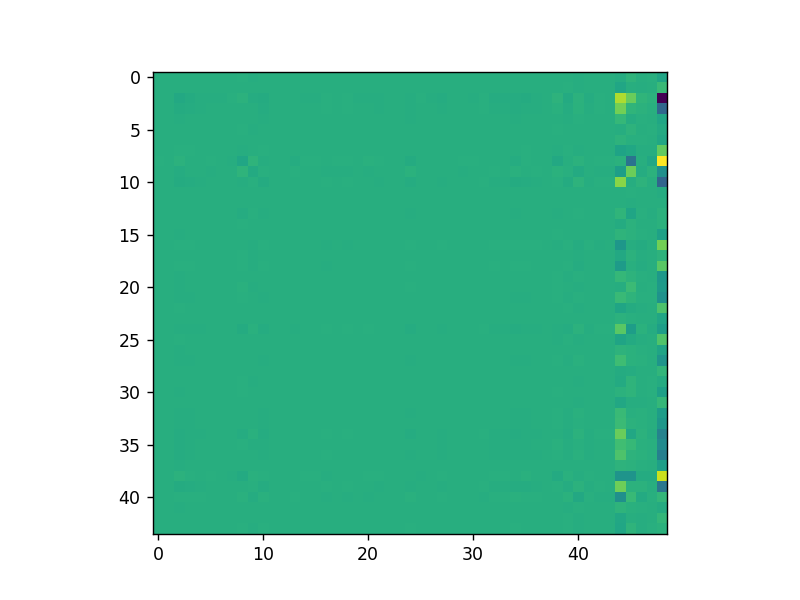

<IPython.core.display.Javascript object>


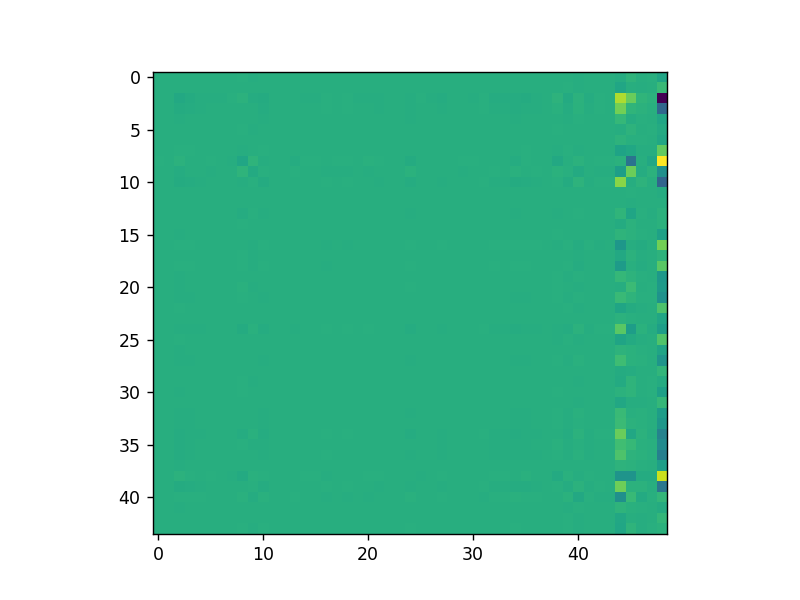

4.05838557204774e-15

In [90]:
plt.figure()
plt.imshow(recon)
plt.figure()
plt.imshow(K)
# # plt.figure()
# # plt.imshow(K-recon)
# diff = K-recon
# diff.max()

<IPython.core.display.Javascript object>


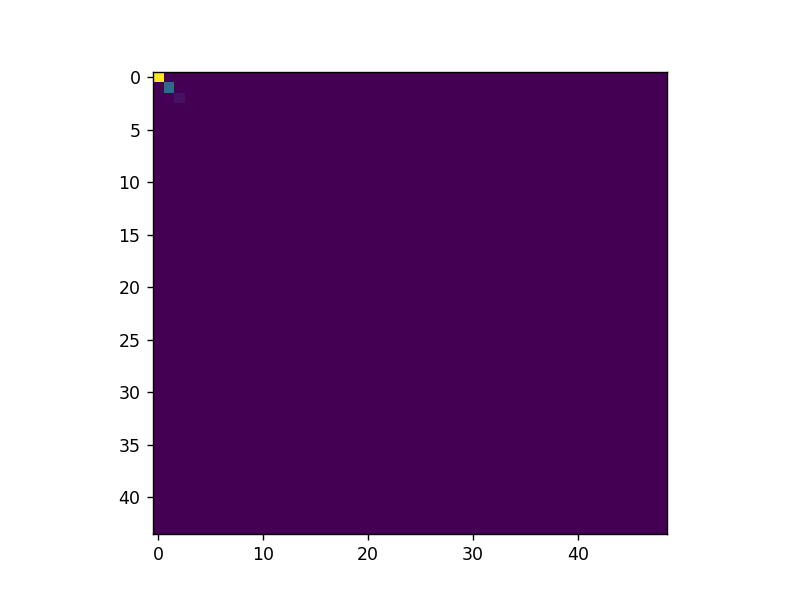

In [86]:
test = 
plt.figure()
plt.imshow(test)

In [75]:
s.shape

(44L,)

In [78]:
u.shape

(44L, 44L)

In [79]:
vh.shape

(49L, 49L)

In [71]:
u*np.diag(s)*vh

ValueError: shapes (44,44) and (49,49) not aligned: 44 (dim 1) != 49 (dim 0)

In [51]:
K.shape

(44L, 49L)

In [16]:
r.keys()

['state_dim',
 'Qv_s',
 'num_targets',
 'num_mag_bins_analyze',
 'A_dic',
 'angle_bin_edges',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'mag_bin',
 'angle_bin',
 'state_label',
 'df_mean',
 'mag_bin_c',
 'kin_var',
 'df_diff',
 'Qfv_s',
 'model_list',
 'n_init',
 'df_lqr',
 'B',
 'task_rot_list',
 'F',
 'bn',
 'R_s',
 'Kn',
 'state_noise_cov',
 'Q',
 'R',
 'mag_bin_edges',
 'df_norm_lqr',
 'offset_var',
 'angle_bin_c',
 'waypoint_speed',
 'A_list',
 'angle_center_for_binning',
 'center',
 'move_lqr',
 'An',
 'Qp_s',
 'state_noise_mean',
 'move_horizon']

In [25]:
r['move_lqr'][0,1.1,'n_do']['K_list'][0].shape

(1L, 20L)

In [27]:
r['move_lqr'][0,1.1,'n_do']['K_list'][0][0,0].shape

(44L, 49L)

In [28]:
r['move_lqr'][0,1.1,'n_null']['K_list'][0][0,0].shape

(44L, 49L)

<IPython.core.display.Javascript object>


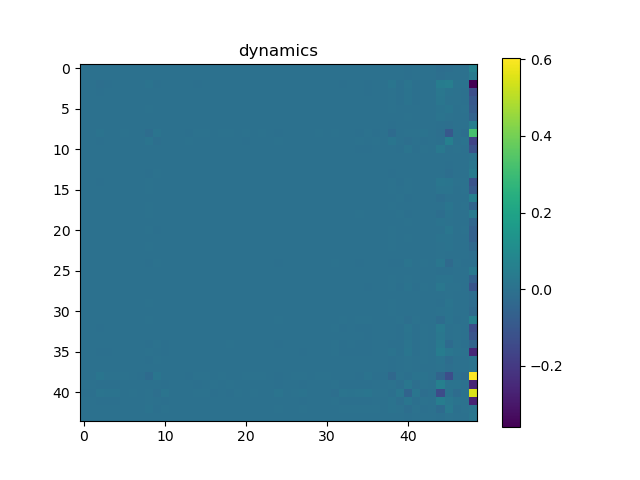

<IPython.core.display.Javascript object>


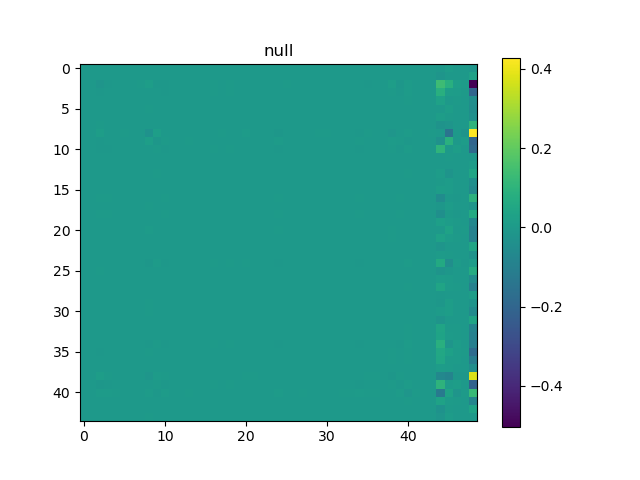

Text(0.5,1,'null')

In [34]:
plt.figure()
plt.imshow(r['move_lqr'][0,1.1,'n_do']['K_list'][0][0,0])
plt.colorbar()
plt.title('dynamics')

plt.figure()
plt.imshow(r['move_lqr'][0,1.1,'n_null']['K_list'][0][0,0])
plt.colorbar()
plt.title('null')

In [35]:
num_neurons

44L

In [42]:
r['move_lqr'][0,1.1,'n_do']['K_list'][0][0,-3]

matrix([[-1.43647594e-03, -1.62455563e-03, -1.90019188e-03, ...,
         -7.58427179e-03,  9.28986821e-03,  2.04048553e-03],
        [-2.74102331e-03, -2.32584732e-03,  1.08509085e-02, ...,
         -1.72280604e-02,  1.22879539e-03, -3.38407956e-01],
        [ 1.74337817e-02,  1.07156377e-02, -1.45273925e-01, ...,
          1.24093987e-01,  7.90889237e-02,  3.95550953e+00],
        ...,
        [ 4.47346025e-03,  3.40713550e-03, -2.49794856e-02, ...,
          2.95010105e-02,  6.27987142e-03,  7.24202295e-01],
        [-4.14125715e-03, -3.62925443e-03,  1.42383308e-02, ...,
         -2.56185043e-02,  4.31314694e-03, -4.60310351e-01],
        [-2.94932913e-03, -2.99607403e-03,  2.44643543e-03, ...,
         -1.67802945e-02,  1.18396610e-02, -1.45904701e-01]])

<IPython.core.display.Javascript object>


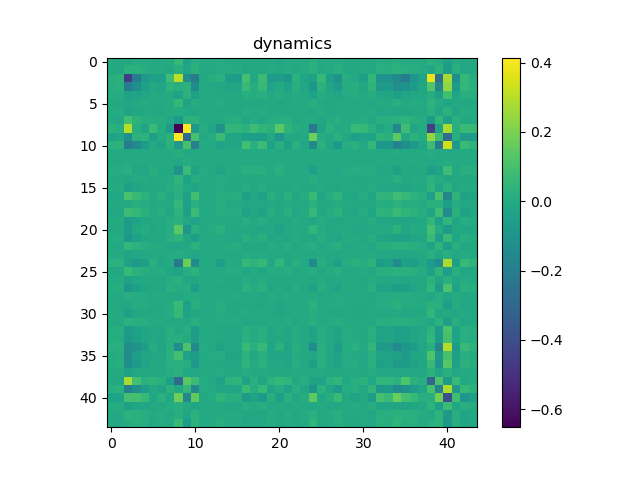

<IPython.core.display.Javascript object>


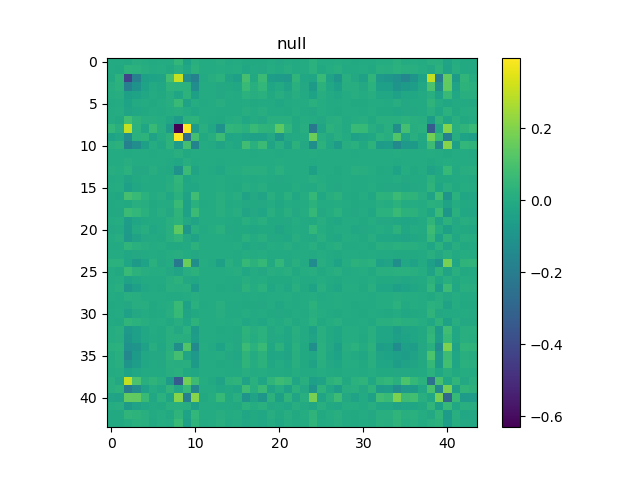

<IPython.core.display.Javascript object>


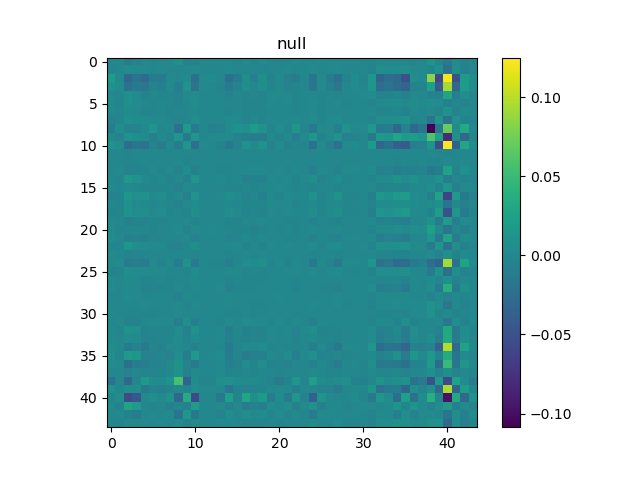

Text(0.5,1,'null')

In [45]:
i_plt = -4

n_do = r['move_lqr'][0,1.1,'n_do']['K_list'][0][0,i_plt][:,:num_neurons]
n_null = r['move_lqr'][0,1.1,'n_null']['K_list'][0][0,i_plt][:,:num_neurons]
n_diff = n_do - n_null

plt.figure()
plt.imshow(n_do)
plt.colorbar()
plt.title('dynamics')

plt.figure()
plt.imshow(n_null)
plt.colorbar()
plt.title('null')

plt.figure()
plt.imshow(n_diff)
plt.colorbar()
plt.title('diff')